<!--NOTEBOOK_HEADER-->
*This notebook contains material from [ND-Pyomo-Cookbook](https://jckantor.github.io/ND-Pyomo-Cookbook);
content is available [on Github](https://github.com/jckantor/ND-Pyomo-Cookbook.git).*
*The text is released under the [CC-BY-NC-ND-4.0 license](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode),
and code is released under the [MIT license](https://opensource.org/licenses/MIT).*

<!--NAVIGATION-->
< [6.1 Unconstrained Scalar Optimization](https://jckantor.github.io/ND-Pyomo-Cookbook/06.01-Unconstrained-Scalar-Optimization.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [6.3 Path Planning for a Simple Car](https://jckantor.github.io/ND-Pyomo-Cookbook/06.03-Path-Planning-for-a-Simple-Car.html) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/06.02-Maximizing-Concentration-of-an-Intermediate-in-a-Batch-Reactor.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/ND-Pyomo-Cookbook/06.02-Maximizing-Concentration-of-an-Intermediate-in-a-Batch-Reactor.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 6.2 Maximizing Concentration of an Intermediate in a Batch Reactor

Keywords: ipopt usage, scipy.minimize_scalar, scipy.odeint, unconstrained optimization

This notebook presents an example of the finding the time period required to acheive an optimal result. Because the period of operation is an unknown 

## 6.2.1 Problem Statement

A desired product $B$ is as an intermediate in a series reactions

\begin{align}
A \overset{k_A}{\longrightarrow} B \overset{k_B}{\longrightarrow} C
\end{align}

where $A$ is a raw material and $C$ is an undesired by-product. The reaction operates isothermally with rate constants $k_A = 0.5\ \mbox{min}^{-1}$ and $k_A = 0.1\ \mbox{min}^{-1}$. The raw material is a solution with concenration $C_{A,f} = 2.0\ \mbox{moles/liter}$.

A 100 liter tank is available for use as a batch reactor. How long should the reaction be operated to maximize the concentration of $B$?

## 6.2.2 Imports

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint
from scipy.optimize import minimize_scalar

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("ipopt") or os.path.isfile("ipopt")):
    if "google.colab" in sys.modules:
        !wget -N -q "https://ampl.com/dl/open/ipopt/ipopt-linux64.zip"
        !unzip -o -q ipopt-linux64
    else:
        try:
            !conda install -c conda-forge ipopt 
        except:
            pass

assert(shutil.which("ipopt") or os.path.isfile("ipopt"))
from pyomo.environ import *
from pyomo.dae import *

     |████████████████████████████████| 9.6 MB 11.7 MB/s 
     |████████████████████████████████| 49 kB 4.2 MB/s 


## 6.2.3 Mathematical model

A material balance for an isothermal stirred batch reactor with a volume $V = 40$ liters and an initial concentration $C_{A,f}$ is given by

\begin{align}
V\frac{dC_A}{dt} & = - V k_A C_A \\
V\frac{dC_B}{dt} & = V k_A C_A - V k_B C_B
\end{align}

Eliminating the common factor $V$

\begin{align}
\frac{dC_A}{dt} & = - k_A C_A \\
\frac{dC_B}{dt} & = k_A C_A - k_B C_B
\end{align}

With an initial concentration $C_{A,f}$. A numerical solution to these equations is shown in the following cell.

In [8]:
import pyomo.environ as pyo
import pyomo.dae as dae #differential equations new idea of a continious set

#DO NOT DO
# most people say impor pyomo.environ as * and import pyomo.dae as * 
#do not do becasue its the last one that's imported 
#matlab pollutes like this, must keep path variable clean
V = 100 #Liters
kA = .5 #mol/L/min
kB = .1 # mol/liter/min
CAf = 2.0 #initial concentration

m = pyo.ConcreteModel('batch reactor')
#reasons for naming the model

#. is bc its object oriented 
m.t = dae.ContinuousSet(bounds = (0,10))
m.cA = pyo.Var(m.t) #creates descion variable as a function of time
m.cB = pyo.Var(m.t)

m.cAdt = dae.DerivativeVar(m.cA)
m.cBdt = dae.DerivativeVar(m.cB)

#now define our differential equation 
#create constraint over set
@m.Constraint(m.t)
def ode_1(m, t):
  return V*m.cAdt[t] == -kA*m.cA[t]*V #could add V

def ode_2(m, t):
  return m.cBdt[t]*V == V*kA*m.cA[t] - kB*m.cB[t]*V

#need initial condition
#don't put m.t in constraint bc it only happens at one time
@m.Constraint()
def ic_1(m):
  return m.cA[0] == 2.0

@m.Constraint()
def ic_2(m):
  return m.cB[0] == 0
#can also say m.cA[0].fix(2.0 or in initial condition)
pyo.TransformationFactory('dae.collocation').apply_to(m)
pyo.SolverFactory('ipopt').solve(m).write()
#for contiual modeling idex set **8

#fetching solution
for t in m.t: #solution turned it into a set of values so looping over set of values
  #prints concentration of A at that time
  #find element t and then () calls function to recall value 
  print(t,m.cA[t](), m.cB[t]())

# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 93
  Number of variables: 123
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.12.13\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.035202741622924805
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
0 2

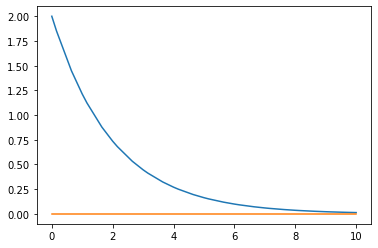

In [9]:
import matplotlib.pyplot as plt

cA = [m.cA[t]() for t in m.t]
cB = [m.cB[t]() for t in m.t]

plt.plot(m.t,cA,m.t,cB)

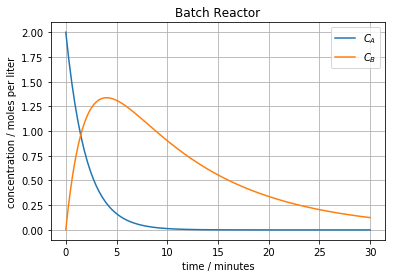

In [ ]:
V = 40     # liters
kA = 0.5   # 1/min
kB = 0.1   # l/min
CAf = 2.0  # moles/liter
# only need A and B bc C = C0 - A - B
def batch(X, t):
    CA, CB = X
    dCA_dt = -kA*CA
    dCB_dt = kA*CA - kB*CB
    return [dCA_dt, dCB_dt]

t = np.linspace(0,30,200)
soln = odeint(batch, [CAf,0], t)
plt.plot(t, soln)
plt.xlabel('time / minutes')
plt.ylabel('concentration / moles per liter')
plt.title('Batch Reactor')
plt.legend(['$C_A$','$C_B$'])
plt.grid(True)

## 6.2.4 Optimization with `scipy.minimize_scalar`

To find the maximum value, we first write a function to compute $C_B$ for any value of time $t$.

In [ ]:
def CB(tf):
    soln = odeint(batch, [CAf, 0], [0, tf])
    return soln[-1][1]

We gain use `minimize_scalar` to find the value of $t$ that minimizes the negative value of $C_B(t)$.|

In [ ]:
minimize_scalar(lambda t: -CB(t), bracket=[0,50])

     fun: -1.3374806339222158
    nfev: 23
     nit: 19
 success: True
       x: 4.023594924340666

In [ ]:
tmax = minimize_scalar(lambda t: -CB(t), bracket=[0,50]).x

print('Concentration c_B has maximum', CB(tmax), 'moles/liter at time', tmax, 'minutes.')

Concentration c_B has maximum 1.3374806339222158 moles/liter at time 4.023594924340666 minutes.


## 6.2.5 Solution using Pyomo

The variable to be found is the time $t_f$ corresponding to the maximum concentration of $B$. For this purpose we introduce a scaled time

$$\tau = \frac{t}{t_f}$$

so that $\tau=1$ as the desired solution. The problem then reads

\begin{align}
\max_{t_f} C_B(\tau=1)
\end{align}

subject to

\begin{align}
\frac{dC_A}{d\tau} & = - t_f k_A C_A \\
\frac{dC_B}{d\tau} & = t_f(k_A C_A - k_B C_B)
\end{align}

The solution to this problem is implemented as a solution to the following Pyomo model.

In [ ]:
V   = 40    # liters
kA  = 0.5   # 1/min
kB  = 0.1   # l/min
cAf = 2.0   # moles/liter

m = ConcreteModel()

m.tau = ContinuousSet(bounds=(0, 1))

m.tf = Var(domain=NonNegativeReals)
m.cA = Var(m.tau, domain=NonNegativeReals)
m.cB = Var(m.tau, domain=NonNegativeReals)

m.dcA = DerivativeVar(m.cA)
m.dcB = DerivativeVar(m.cB)

m.odeA = Constraint(m.tau, 
    rule=lambda m, tau: m.dcA[tau] == m.tf*(-kA*m.cA[tau]) if tau > 0 else Constraint.Skip)
m.odeB = Constraint(m.tau,
    rule=lambda m, tau: m.dcB[tau] == m.tf*(kA*m.cA[tau] - kB*m.cB[tau]) if tau > 0 else Constraint.Skip)

m.ic = ConstraintList()
m.ic.add(m.cA[0]  == cAf)
m.ic.add(m.cB[0]  == 0)

m.obj = Objective(expr=m.cB[1], sense=maximize)

TransformationFactory('dae.collocation').apply_to(m)
SolverFactory('ipopt').solve(m)
print('Concentration c_B has maximum', m.cB[1](), 'moles/liter at time', m.tf(), 'minutes.')

Concentration c_B has maximum 1.3374805810221078 moles/liter at time 4.023594178375688 minutes.


<!--NAVIGATION-->
< [6.1 Unconstrained Scalar Optimization](https://jckantor.github.io/ND-Pyomo-Cookbook/06.01-Unconstrained-Scalar-Optimization.html) | [Contents](toc.html) | [Tag Index](tag_index.html) | [6.3 Path Planning for a Simple Car](https://jckantor.github.io/ND-Pyomo-Cookbook/06.03-Path-Planning-for-a-Simple-Car.html) ><p><a href="https://colab.research.google.com/github/jckantor/ND-Pyomo-Cookbook/blob/master/docs/06.02-Maximizing-Concentration-of-an-Intermediate-in-a-Batch-Reactor.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://jckantor.github.io/ND-Pyomo-Cookbook/06.02-Maximizing-Concentration-of-an-Intermediate-in-a-Batch-Reactor.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>